In [71]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import torch

In [72]:
# importing torchvision for working with Image data and downloading data using classes
import torchvision
from torchvision.datasets import MNIST 

train_dataset = MNIST(root='data/', train= True, download= True)
test_dataset = MNIST(root='data/', train= False, download= True)

print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [73]:
# checking the type of train and test dataset
# it is pair having image and label
print(train_dataset[0])
print(test_dataset[0])

(<PIL.Image.Image image mode=L size=28x28 at 0x7F0427DDC810>, 5)
(<PIL.Image.Image image mode=L size=28x28 at 0x7F0427D3A9D0>, 7)


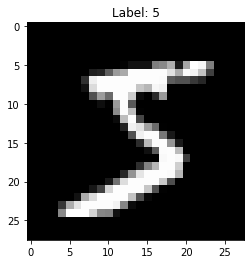

In [74]:
# plotting the image
img,label = train_dataset[0]
plt.imshow(img, cmap='gray')
plt.title(f"Label: {label}")
plt.show()

In [75]:
# using transform functionality of torchvision to convert images into Tensor data
import torchvision.transforms as transforms

train_dataset = MNIST(root='data/', train= True, transform=transforms.ToTensor())
test_dataset = MNIST(root='data/', train= False, transform=transforms.ToTensor())

print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [76]:
# checking the above conversion to Tensor

img, label = train_dataset[0]
print("Image Shape: ", img.shape)

Image Shape:  torch.Size([1, 28, 28])


In [77]:
"""
Data preparation for the model. Random split the data into training_data, validation_data.
 - training data: used to train the model
 - validation data: used to evaluate the model during training, adjusting the hyperparameters( learning rate, momentum etc)
 - test data : used to compare the different models / approaches 

## random_split from torch utlis is used for splitting the data
"""
from torch.utils.data import random_split

train_ds, val_ds = random_split(train_dataset, [50000,10000])
print(len(train_ds))
print(len(val_ds))

50000
10000


In [78]:
"""
Preparing the batches from given train_ds
Pytorch's DataLoader is responsible for managing batches. We can create a DataLoader from any Dataset. DataLoader makes it easier to iterate over batches.
"""
from torch.utils.data import DataLoader

batch_size = 128
train_loader = DataLoader(train_ds, batch_size, shuffle= True)
val_loader = DataLoader(val_ds, batch_size, shuffle= True)

In [79]:
# Define the function to get the input_features and output_features dimensions, required to create a fully connected layer

def input_output_features_dimensions(loader):
  for img, label in loader:
    batch, channel, height, width = img.shape
    break
  return {'in_dim':channel*height*width, 'out_dim': 10}

x = input_output_features_dimensions(train_loader)

In [80]:
# creating measurement unit for evaluating the model accuracy

def accuracy(outputs, labels):

  #output size: 128x10
  _, index = torch.max(outputs, dim=1)   # collecting the index of max_value which tells the label (index = 128x1)
  bool_matrix = torch.eq(index, labels)
  correct_classified = torch.sum(bool_matrix)

  return torch.tensor(correct_classified.item()/len(bool_matrix))

In [81]:
# creating the custom MNIST model class from nn.module of pytorch using the inheritance concept of oops
import torch.nn as nn
import torch.nn.functional as F

dim = input_output_features_dimensions(train_loader)
input_features = dim['in_dim']
output_features = dim['out_dim']


class MNIST_sanjeev(nn.Module):

  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(input_features, output_features)   # this will create the weight and bias matrices when an object is class is created
  

  """"

  # For understanding, it means when we create the MNIST_sanjeev class object and when we use this object as function over the batch of images, in the backend it will call the 
  __call__ magic function, which further call the self.forward(batch_image)
  # In nutshell whenever we want to use the object of class as function we have to define this thing using __call___ magic function
  # nn.Module
  class Module(object):

      def __call__(self, x):
          # Simplified
          # Actual implementation has validation and gradient tracking.
          return self.forward(x)
  """

  def forward(self, image_batch):
    image_batch = image_batch.reshape(-1,input_features)    # -1 means python will automatically decide this dimension as per the input data dimension
    out = self.fc1(image_batch)                                           
    return out
  
  def training_step(self, batch):
    imgs, labels = batch
    out = self(imgs)               # self here denotes the obj of the class ---> for ex: model(imgs)--> which call ---> model.forward(imgs)
    loss = F.cross_entropy(out, labels)
    return loss

  def validation_step(self, batch):
    imgs, labels = batch
    out = self(imgs)
    loss = F.cross_entropy(out, labels)
    acc = accuracy(out, labels)
    return{'val_loss':loss, 'val_acc': acc}
  
  def validation_epoch_end(self, outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    batch_accs = [x['val_acc'] for x in outputs]

    epoch_loss = torch.stack(batch_losses).mean()
    epoch_acc = torch.stack(batch_accs).mean()

    return{'val_loss':epoch_loss.item(), 'val_acc':epoch_acc.item()}
  
  def print_epoch_end_result(self, epoch, final_result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, final_result['val_loss'], final_result['val_acc']))


In [82]:
def fit(no_of_epochs, lr, model, train_loader, val_loader, opt_func =torch.optim.SGD):

  optimizer = opt_func(model.parameters(), lr)
  record = []

  for epoch in range(no_of_epochs):

    # Training Phase
    for batch in train_loader:
      loss = model.training_step(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

    # Validation Phase

    mid_result = [model.validation_step(batch) for batch in val_loader]    # give list of dict of val_loss and val_acc
    final_result = model.validation_epoch_end(mid_result)                  # give the epoch loss and epoch acc
    model.print_epoch_end_result(epoch,final_result)

    record.append(final_result)
  
  return record

In [83]:
# creating the object of the class
model = MNIST_sanjeev()

In [84]:
for batch in val_loader:
  batch_1 = batch
  break

result0 = model.validation_step(batch)
print(result0)

{'val_loss': tensor(2.3296, grad_fn=<NllLossBackward0>), 'val_acc': tensor(0.1719)}


In [85]:
history1 = fit(5,0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9485, val_acc: 0.6153
Epoch [1], val_loss: 1.6769, val_acc: 0.7371
Epoch [2], val_loss: 1.4771, val_acc: 0.7709
Epoch [3], val_loss: 1.3269, val_acc: 0.7888
Epoch [4], val_loss: 1.2114, val_acc: 0.7992


In [86]:
history2 = fit(5,0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1186, val_acc: 0.8071
Epoch [1], val_loss: 1.0444, val_acc: 0.8144
Epoch [2], val_loss: 0.9822, val_acc: 0.8222
Epoch [3], val_loss: 0.9353, val_acc: 0.8239
Epoch [4], val_loss: 0.8893, val_acc: 0.8320


In [87]:
history3 = fit(5,0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8515, val_acc: 0.8351
Epoch [1], val_loss: 0.8235, val_acc: 0.8377
Epoch [2], val_loss: 0.7948, val_acc: 0.8415
Epoch [3], val_loss: 0.7719, val_acc: 0.8410
Epoch [4], val_loss: 0.7493, val_acc: 0.8452


In [88]:
history4 = fit(5,0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7289, val_acc: 0.8477
Epoch [1], val_loss: 0.7141, val_acc: 0.8495
Epoch [2], val_loss: 0.6952, val_acc: 0.8511
Epoch [3], val_loss: 0.6854, val_acc: 0.8507
Epoch [4], val_loss: 0.6703, val_acc: 0.8536


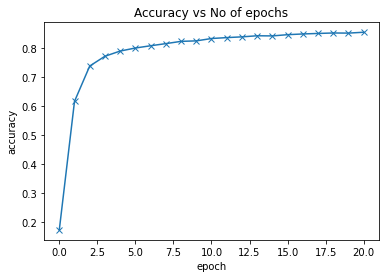

In [89]:
history = [result0] + history1 + history2 + history3 + history4

accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No of epochs')
plt.show()